# New Plan

1. Split data into 4 seasons - process NOAA and CAISO data together.ipynb
2. Select a month in the season - I choose august bc no holidays hehe
3. Split season into weekdays and weekends/holidays
4. Output prediction for the whole season
5. Check it against the results from CAISO 

train with the average of 2019+2020 data

predict with 2021 data

**spring = march, april, may**

**summer = june, july, august**

juneteenth (only in 2021)

july 4th

august has no holidays 

**fall = september, october, november**

**winter = december, january, februrary**

https://www.mikulskibartosz.name/time-in-machine-learning/



In [4]:
import tensorflow 
import os
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from keras import callbacks
from tensorflow.keras.losses import MeanSquaredError
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import joblib
from tensorflow import keras
from google.colab import drive
import os

drive.mount('/content/drive/', force_remount=True)
pd.options.mode.chained_assignment = None

Mounted at /content/drive/


# Functions

In [5]:
#purpose: scale the values of data points to be between 0 -> 1
#input: df = dataframe
#output: df = scaled df, allScalers = scalers for all variables

def scaleAllData(df, skip = 'is_weekend'):
    allScalers = []
    for column in df.columns:
      scaler = MinMaxScaler(feature_range=(0,1))
      df1 = df[column]
      df[column] = scaler.fit_transform(np.array(df1.values.reshape(-1, 1)))
      allScalers.append(scaler)
    return df, allScalers

In [6]:
#purpose: split data into the inputs and output prediction values
#input: df = dataframe, predictColPos = position of the var that you want to predict, window_size = timesteps, default is 1
#output: X = input data, y = what you want to predict data

def df_to_X_y(df, predictColPos, window_size= 1): #1 day of feature data
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)- window_size):
        row = [ r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][predictColPos] 
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
#purpose: make df; meaning it has all the weather var values scaled, the is weekend/weekday split, and megawatts
#inputs: df = dataframe, cols = the columns that we should have as mentioned above, directory = where to save scalers to, beg = position of df to start from, end = position of df to end at
#outputs: prepared df

# select df for specific season; I am choosing summer
def prepareDf(df, cols_rearranged, baseLSTM_Directory, location, numDaysInMonth, beg = 0, end = -1):
  df = df.iloc[beg:end, :]
  df['date'] = pd.to_datetime(df['date'], format='%m-%dT%H:%M:%S')
  df['date']= df["date"].map(lambda x: x.replace(year=2019))
  df.index = df['date']
  
  df['Seconds'] = df.index.map(pd.Timestamp.timestamp)
  day = 60 * 60 * 24 #60 s in a min, 60 min in an hour, 24 hours in a day
  month = numDaysInMonth * 60 * day #num seconds in a month of AUGUST
  df['Day sin'] = np.sin(df['Seconds']*2*(np.pi/day))
  df['Day cos'] = np.cos(df['Seconds']*2*(np.pi/day))
  df['Month sin'] = np.sin(df['Seconds']*2*(np.pi/month))
  df['Month cos'] = np.cos(df['Seconds']*2*(np.pi/month))
  
  # starting from 06-01 which is a Sunday in 2019
  # dates are from 0 - 6
  # 0 1 2 3 4 5 6
  # M T W T F S S
  df['date'] = pd.to_datetime(df.date)
  df['day_of_week'] = df.date.dt.weekday
  # I want Sat/Sun to be treated the same, because they are both a weekend 
  df['is_weekend'] = df['day_of_week'].isin([5, 6])
  df['is_weekend'] = df['is_weekend'].astype(int)
  df.drop('date', axis=1, inplace=True)
  df.drop('day_of_week', axis=1, inplace=True)  

  df = df[cols_rearranged]

  #scaling and saving scalers
  return df

In [8]:
#purpose: generate a energy consumption model 
#input: df=dataframe, numEpochs = epochs for model training, baseLSTM_Directory = directory for LSTM, location = place sf/sac/sd/etc.
#output: rmse = rmse value, model = the model that resulted in that rmse value

def energyConsumptionModel(df, numEpochs, baseLSTM_Directory, location, window_size):
    megawattsPos = len(df.columns) - 1
    X, y = df_to_X_y(df, megawattsPos, window_size) 
    #############################################train and test #########################################################
    train_percent = 0.8
    validation_percent = 0.2

    train_percent_split = int(train_percent * len(X))
    validation_percent_split = int(validation_percent * len(X)) + train_percent_split
    print(validation_percent_split)

    X_train, y_train = X[:train_percent_split], y[:train_percent_split]
    X_val, y_val = X[train_percent_split:validation_percent_split], y[train_percent_split:validation_percent_split] #validation
    # X_train.shape, y_train.shape, X_val.shape, y_val.shape

    ############################################# create model #########################################################
    model = Sequential()
    model.add(LSTM(64,input_shape=(X_train.shape[1],X_train.shape[2]))) # input layer; 31 data inputs, 1 step (1 hr)
    model.add(Dense(32, 'relu')) #hidden layer 1
    model.add(Dense(32, 'relu')) #hidden layer 2
    model.add(Dense(1, 'linear')) #output layer
    
    storeModel = baseLSTM_Directory + 'model' + location +'/'
    
    cp = ModelCheckpoint(storeModel, save_best_only = True) #I want to only save the best model (lowest validation loss)
    model.compile(loss = MeanSquaredError(), optimizer = Adam(), metrics = [RootMeanSquaredError()])
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs = numEpochs, callbacks = [cp])

    ######################################### predictions and rmse ######################################################
    train_predictions = model.predict(X_train).flatten()
    train_results = pd.DataFrame(data = {'Train Predictions': train_predictions, 'Actuals':y_train})
    rmse = mean_squared_error(train_predictions, y_train, squared=False)
    print("RMSE value: ", rmse)
    return rmse, model

In [9]:
#purpose: selecting the best energy consumption model 
#input: iters = num iterations to find best model, df = dataframe, numEpochs = number of epochs for training model, baseLSTM_Directory = LSTM directory, location = place sf/sd/sac/etc.
#output: return a list of the best performing model for each weather var

def getBestEnergyConsumptionModel(iters, df, numEpochs, baseLSTM_Directory, location, window_size):
    getBest = {}
    for i in range(iters):
        rmse, model = energyConsumptionModel(df, numEpochs, baseLSTM_Directory, location, window_size)
        getBest.update({rmse:model})
    lowestRmse = min(getBest.keys())
    return getBest[lowestRmse]

In [10]:
#purpose: make the final future energy consumption predictions for future hours
#input: bestEnergyConsumptionModel = best model to do prediction, data = prev day so that we can make future predictions, howManyFutureHours = how many hours to predict, window_size = timesteps, numVarInputs = number of variables for the model (energy consumption, weather data vars)
#output: future energy consumption
# futurePredictions_EC(bestEnergyConsumptionModel, df2021, howManyFutureHours, window_size, numVarInputs)
def futurePredictions_EC(bestEnergyConsumptionModel, dataForPrediction, howManyFutureHours, window_size, numVarInputs):
    future_outputs=[]
    i=0
    while(i<howManyFutureHours): #for the next thirty hours
      x_input = np.array(dataForPrediction.iloc[i:window_size+i, :])
      # print('x_input: ', x_input)
      x_input = x_input.reshape(1, window_size, numVarInputs)
      yhat = bestEnergyConsumptionModel.predict(x_input, verbose=0)#.flatten()
      # print(yhat[0])
      future_outputs.append(yhat[0][0])
      i=i+1

    return future_outputs

In [11]:
def oneMonthRepresentation_july():
  pathToData = '/content/drive/MyDrive/Fairness ML/FairnessML_git/Datasets/CAISO_NetDemand_Megawatts_google/' 
  pathToSaveData = '/content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/july/' 

  dates2019 = ['20190701','20190702','20190703','20190704','20190705','20190706','20190707','20190708','20190709','20190710',
               '20190711','20190712','20190713','20190714','20190715','20190716','20190717','20190718','20190719',
               '20190720','20190721','20190722','20190723','20190724','20190725','20190726','20190727','20190728','20190729','20190730','20190731']
  dates2020 = ['20200701','20200702','20200703','20200704','20200705','20200706','20200707','20200708','20200709','20200710',
               '20200711','20200712','20200713','20200714','20200715','20200716','20200717','20200718','20200719','20200720',
               '20200721','20200722','20200723','20200724','20200725','20200726','20200727','20200728','20200729','20200730','20200731']
  dates2021 = ['20210701','20210702','20210703','20210704','20210705','20210706','20210707','20210708','20210709','20210710','20210711',
               '20210712','20210713','20210714','20210715','20210716','20210717','20210718','20210719','20210720','20210721','20210722',
               '20210723','20210724','20210725','20210726','20210727','20210728','20210729','20210730','20210731']
  july = ['07-01','07-02','07-03','07-04','07-05','07-06','07-07','07-08','07-09','07-10','07-11','07-12','07-13','07-14','07-15',
          '07-16','07-17','07-18','07-19','07-20','07-21','07-22','07-23','07-24','07-25','07-26','07-27','07-28','07-29','07-30','07-31']
  
  xaxis =[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
  beg = 'CAISO-netdemand-'
  end = '-Megawatts.csv'
  result2019 = pd.DataFrame()
  result2020 = pd.DataFrame()
  result2021 = pd.DataFrame()
  for i in range(len(dates2019)):
    #2019
    read2019 = pathToData + beg + dates2019[i] + end
    df2019 = pd.read_csv(read2019)
    df2019.drop('date', axis=1, inplace=True)
    result2019 = pd.concat([result2019, df2019], axis=1)
    result2019.iloc[:1, :]
    result2019['mean'] = result2019.mean(axis=1)

    #2020
    read2020 = pathToData + beg + dates2020[i] + end
    df2020 = pd.read_csv(read2020)
    df2020.drop('date', axis=1, inplace=True)
    result2020 = pd.concat([result2020, df2020], axis=1)
    result2020.iloc[:1, :]
    result2020['mean'] = result2020.mean(axis=1)
    #2021
    read2021 = pathToData + beg + dates2021[i] + end
    df2021 = pd.read_csv(read2021)
    df2021.drop('date', axis=1, inplace=True)
    result2021 = pd.concat([result2021, df2021], axis=1)
    result2021.iloc[:1, :]
    result2021['mean'] = result2021.mean(axis=1)

  plt.plot(result2019['mean'], color = 'blue', label = '2019')
  plt.plot(result2020['mean'], color = 'red', label = '2020')
  plt.plot(result2021['mean'], color = 'green', label = '2021')

  plt.xticks(xaxis)
  plt.xlabel('Hours')
  plt.ylabel('Megawatts')
  plt.suptitle('July')
  plt.legend()
  plt.savefig(pathToSaveData+ 'julyAvg.jpg', bbox_inches = 'tight', dpi=150)
  plt.show()
  rms2019_2020 = mean_squared_error(result2019['mean'], result2020['mean'], squared=False)
  rms2019_2021 = mean_squared_error(result2019['mean'], result2021['mean'], squared=False)
  rms2020_2021 = mean_squared_error(result2020['mean'], result2021['mean'], squared=False)
  avg3 = (rms2019_2020 + rms2019_2021 + rms2020_2021)/3
  print('Average RMSE between 2019-2020, 2019-2021, 2020-2021: ', avg3)

  averageJuly = pd.concat([result2019['mean'], result2020['mean']], axis=1)
  finalRep = averageJuly.mean(axis=1)
  return finalRep

# Run

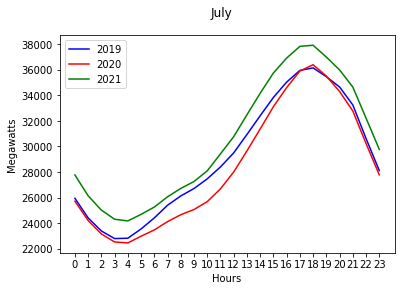

Average RMSE between 2019-2020, 2019-2021, 2020-2021:  1496.465666014826


In [12]:
julyRep = oneMonthRepresentation_july()

In [87]:
pathToData = '/content/drive/MyDrive/Fairness ML/FairnessML_git/Datasets/2019_2020/'
dataFile = [f for f in listdir(pathToData) if isfile(join(pathToData, f))] 
for file in dataFile:
    print(file)
    # df = pd.read_csv(pathToDir + file)

print('-------')
#for now, I will only use SF data 
pos = 3
iteration = 2

fileRead = pathToData + dataFile[pos]
print('fileRead: ', fileRead)
df = pd.read_csv(fileRead)
dfOriginal = pd.read_csv(fileRead)

# 2021 data
pathToData1 = '/content/drive/MyDrive/Fairness ML/FairnessML_git/Datasets/2021/'
dataFile1 = [f for f in listdir(pathToData1) if isfile(join(pathToData1, f))] 
for file in dataFile1:
    print(file)
    # df = pd.read_csv(pathToDir + file)
 
fileRead1 = pathToData1 + dataFile1[pos]
print('fileRead: ', fileRead1)
df2021 = pd.read_csv(fileRead1)

howManyFutureHours = 24
window_size = 24
numEpochs = 20
iters = 1
beg = 4344
end = 5088
numDaysInMonth = 31


baseLSTM_Directory = '/content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/'
locArray = ['_SAC', '_SF', '_SD', '_LA']
location = locArray[pos]
##### MAKE SURE YOU CHANGED ALL VARIABLES RELATED TO LOCATION ABOVE BEFORE RUNNING THIS CELL
# bestPerformingModel(howManyFutureHours, window_size, numEpochs, iters, cols_rearranged, columns, df, currentDirectory, location)


SAC-yearAvg-NOAA-and-Megawatts.csv
SF-yearAvg-NOAA-and-Megawatts.csv
SD-yearAvg-NOAA-and-Megawatts.csv
LA-yearAvg-NOAA-and-Megawatts.csv
-------
fileRead:  /content/drive/MyDrive/Fairness ML/FairnessML_git/Datasets/2019_2020/LA-yearAvg-NOAA-and-Megawatts.csv
SAC-NOAA-and-Megawatts.csv
SF-NOAA-and-Megawatts.csv
SD-NOAA-and-Megawatts.csv
LA-NOAA-and-Megawatts.csv
fileRead:  /content/drive/MyDrive/Fairness ML/FairnessML_git/Datasets/2021/LA-NOAA-and-Megawatts.csv


503
Epoch 1/20
13/13 [==============================] - ETA: 0s - loss: 0.0816 - root_mean_squared_error: 0.2857

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_LA/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_LA/assets


13/13 [==============================] - 9s 490ms/step - loss: 0.0816 - root_mean_squared_error: 0.2857 - val_loss: 0.0486 - val_root_mean_squared_error: 0.2205
Epoch 2/20
12/13 [==========================>...] - ETA: 0s - loss: 0.0185 - root_mean_squared_error: 0.1360

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_LA/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_LA/assets


13/13 [==============================] - 5s 412ms/step - loss: 0.0181 - root_mean_squared_error: 0.1347 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0663
Epoch 3/20
12/13 [==========================>...] - ETA: 0s - loss: 0.0083 - root_mean_squared_error: 0.0911

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_LA/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_LA/assets


13/13 [==============================] - 6s 462ms/step - loss: 0.0084 - root_mean_squared_error: 0.0914 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0572
Epoch 4/20
13/13 [==============================] - 0s 22ms/step - loss: 0.0069 - root_mean_squared_error: 0.0831 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0802
Epoch 5/20
13/13 [==============================] - 0s 21ms/step - loss: 0.0057 - root_mean_squared_error: 0.0754 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0602
Epoch 6/20
11/13 [========================>.....] - ETA: 0s - loss: 0.0053 - root_mean_squared_error: 0.0730

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_LA/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_LA/assets


13/13 [==============================] - 5s 418ms/step - loss: 0.0054 - root_mean_squared_error: 0.0734 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0496
Epoch 7/20
13/13 [==============================] - 0s 21ms/step - loss: 0.0052 - root_mean_squared_error: 0.0721 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0504
Epoch 8/20
10/13 [======================>.......] - ETA: 0s - loss: 0.0049 - root_mean_squared_error: 0.0697

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_LA/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_LA/assets


13/13 [==============================] - 6s 465ms/step - loss: 0.0049 - root_mean_squared_error: 0.0700 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0428
Epoch 9/20
13/13 [==============================] - 0s 21ms/step - loss: 0.0046 - root_mean_squared_error: 0.0680 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0445
Epoch 10/20
13/13 [==============================] - 0s 21ms/step - loss: 0.0042 - root_mean_squared_error: 0.0651 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0535
Epoch 11/20
13/13 [==============================] - 0s 21ms/step - loss: 0.0037 - root_mean_squared_error: 0.0610 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0447
Epoch 12/20
13/13 [==============================] - 0s 21ms/step - loss: 0.0036 - root_mean_squared_error: 0.0596 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0452
Epoch 13/20
11/13 [========================>.....] - ETA: 0s - loss: 0.0031 - root_mean_squared_error: 0.0561

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_LA/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_LA/assets


13/13 [==============================] - 5s 407ms/step - loss: 0.0032 - root_mean_squared_error: 0.0567 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0382
Epoch 14/20
13/13 [==============================] - ETA: 0s - loss: 0.0030 - root_mean_squared_error: 0.0549

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_LA/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_LA/assets


13/13 [==============================] - 6s 473ms/step - loss: 0.0030 - root_mean_squared_error: 0.0549 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0359
Epoch 15/20
13/13 [==============================] - 0s 23ms/step - loss: 0.0025 - root_mean_squared_error: 0.0504 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0492
Epoch 16/20
13/13 [==============================] - 0s 22ms/step - loss: 0.0030 - root_mean_squared_error: 0.0552 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0428
Epoch 17/20
10/13 [======================>.......] - ETA: 0s - loss: 0.0029 - root_mean_squared_error: 0.0542

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_LA/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_LA/assets


13/13 [==============================] - 6s 462ms/step - loss: 0.0029 - root_mean_squared_error: 0.0534 - val_loss: 9.9783e-04 - val_root_mean_squared_error: 0.0316
Epoch 18/20
13/13 [==============================] - 0s 23ms/step - loss: 0.0020 - root_mean_squared_error: 0.0445 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0345
Epoch 19/20
13/13 [==============================] - 0s 21ms/step - loss: 0.0017 - root_mean_squared_error: 0.0410 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0350
Epoch 20/20
10/13 [======================>.......] - ETA: 0s - loss: 0.0016 - root_mean_squared_error: 0.0396

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_LA/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_LA/assets


13/13 [==============================] - 5s 400ms/step - loss: 0.0015 - root_mean_squared_error: 0.0392 - val_loss: 7.9200e-04 - val_root_mean_squared_error: 0.0281
RMSE value:  0.032507165478797846


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/Best_LA/energyModel/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/Best_LA/energyModel/assets


--------------------------------- SAVED BEST ENERGY CONSUMPTION MODEL -----------------------------------
----------------------------FINAL, DONE;----------------------------
rmse value:  2948.770999809123


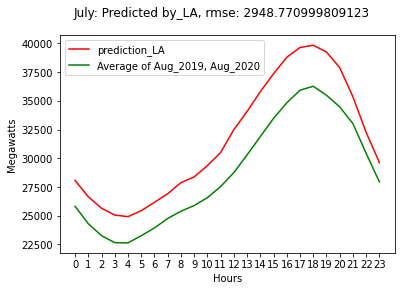

In [88]:
df.columns[1:-1]
cols_rearranged = list(df.columns[1:-1])
cols_rearranged.append('is_weekend')
cols_rearranged.append('Day sin')
cols_rearranged.append('Day cos')
cols_rearranged.append('Month sin')
cols_rearranged.append('Month cos')
cols_rearranged.append('AvgMegawatts2019-2020')

df = prepareDf(df, cols_rearranged, baseLSTM_Directory, location, numDaysInMonth, beg, end)
df = df[df.is_weekend == 0] # only keeping weekday data
df.drop('is_weekend', axis = 1, inplace =True)
df, allScalers = scaleAllData(df)
#################### remove holidays, for july: july 4th #######################
julyFourth =[72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95]
df.drop(df.index[julyFourth], inplace=True)

# saveScalers(df, baseLSTM_Directory, location, allScalers) #saving scalers

bestEnergyConsumptionModel = getBestEnergyConsumptionModel(iters, df, numEpochs, baseLSTM_Directory, location, window_size)

saveModelsDir = baseLSTM_Directory +'Best'+ location + '/'
bestEnergyConsumptionModel.save(saveModelsDir +'energyModel/', save_format = 'utf')

print("--------------------------------- SAVED BEST ENERGY CONSUMPTION MODEL -----------------------------------")

########################################## GET DATA FOR FUTURE PREDICTION #######################################################
cols_rearranged.pop()
cols_rearranged.append('Megawatts_2021') #preparing cols for 2021 data
df2021 = prepareDf(df2021, cols_rearranged, baseLSTM_Directory, location, numDaysInMonth, beg, end)
df2021 = df2021[df2021.is_weekend == 0] # only keeping weekday data
df2021.drop('is_weekend', axis = 1, inplace =True)
df2021, allScalers = scaleAllData(df2021)
megawattsPos = megawattsPos = len(df2021.columns) - 1
X, y = df_to_X_y(df2021, megawattsPos, window_size) 

# # ########################################## FUTURE PREDICTION #######################################################
numVarInputs = len(df2021.columns)
lastTwoDays = len(df2021) - 48
df2021 = df2021.iloc[lastTwoDays: , :]
lst_output = futurePredictions_EC(bestEnergyConsumptionModel, df2021, howManyFutureHours, window_size, numVarInputs)
# # ########################################### check output #######################################################
megawattsScaler = allScalers[len(allScalers)-1]

predictedVals = megawattsScaler.inverse_transform(np.array(lst_output).reshape(-1,1))
predicted24Hours = pd.DataFrame(predictedVals)

print("----------------------------FINAL, DONE;----------------------------")
rmse = mean_squared_error(julyRep, predicted24Hours, squared=False)
print('rmse value: ', rmse)

plt.plot(predicted24Hours, color = 'red', label = 'prediction'+location)
plt.plot(julyRep, color = 'green', label = 'Average of Aug_2019, Aug_2020')
xaxis =[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
plt.xticks(xaxis)
plt.xlabel('Hours')
plt.ylabel('Megawatts')
plt.suptitle('July: Predicted by'+location+', rmse: ' + str(rmse))
plt.legend()
pathToSaveData = '/content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/byMonth/'
plt.savefig(pathToSaveData+location+ '/July'+location+'_'+str(iteration)+'.jpg', bbox_inches = 'tight', dpi=150)
plt.show()

In [2]:
# determine holidays
# pos = 24 * 3
# end = 24*4
# df.iloc[pos:end, :]

# for i in range(pos, end):
#   print(str(i)+', ',  end ='')

# julyFourth =[72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95]